In [18]:
import torch
import os
import pandas as pd
from x_transformers import TransformerWrapper, Decoder
from x_transformers.autoregressive_wrapper import AutoregressiveWrapper
import numpy as np
import csv


In [ ]:

# =============================================================================
#                            Helper Functions
# =============================================================================

def load_saved_model(model_dir, model_name, epoch, max_length, num_words, device):
    """Load the saved model and its weights."""
    model = TransformerWrapper(
        num_tokens=num_words,
        max_seq_len=max_length,
        attn_layers=Decoder(
            dim=256,
            depth=12,
            heads=8,
            attn_dim_head=64,
            rotary_pos_emb=True,
            attn_flash=True
        )
    )
    model = AutoregressiveWrapper(model)
    print(f"Current Working Directory: {os.getcwd()}")
    model_path = os.path.join(model_dir, f"LifeGPT_multi_grid_epoch_{epoch}.pt")
    print("Trying to load model from:", model_path)
    model.load_state_dict(torch.load(model_path))

    model.to(device)
    model.eval()
    print(f"Model for epoch {epoch} loaded successfully.")
    return model


def count_mismatches(ground_truth, pred):
    """Calculate mismatches and accuracy."""
    mismatches = sum(1 for gt, p in zip(ground_truth, pred) if gt != p)
    accuracy = 1 - mismatches / len(ground_truth)
    return mismatches, accuracy


def calculate_grid_width(input_string):
    """Calculate the grid width based on the numerical values in the input string."""
    grid_length = input_string.count("0") + input_string.count("1")
    return int(grid_length ** 0.5) if grid_length > 0 else 0

# =============================================================================
#                            Load Data
# =============================================================================

data_path = "datasets\\"
test_file = os.path.join(data_path, "conway_multi_grid_test_20250107_181732.csv")

df_test = pd.read_csv(test_file)

# Define parameters
start_char = "@"
end_char = "$"
mask_char = ["_"]
future_steps_list = [2]

# Helper functions for data processing
def generate_data(df, future_steps):
    X_data = []
    for i in range(len(df['State 1'])):
        future_state_col = f"State {future_steps}"
        if future_state_col in df.columns:
            str_ = f"{start_char}PredictNextState<{df['State 1'][i]}> [{df[future_state_col][i]}]{end_char}"
            X_data.append(str_)
    return X_data

X_data_test = {steps: generate_data(df_test, steps) for steps in future_steps_list}

# Tokenizer class from provided code
class Tokenizer:
    def __init__(self, n_pad: int, device: torch.device, pad_byte: int = 0):
        self.n_pad = n_pad
        self.device = device
        self.pad_byte = pad_byte

    def tokenize_str(self, sentence: str, encoding="utf8", do_padding=True):
        base = list(bytes(sentence, encoding))
        if do_padding:
            if len(base) < self.n_pad:
                base.extend([self.pad_byte] * (self.n_pad - len(base)))
            assert len(base) == self.n_pad, f"n_pad is too small. Need at least {len(base)}."
        tensor = torch.Tensor(base)
        return tensor.long().to(self.device)

    def texts_to_sequences(self, texts, encoding="utf8", do_padding=True):
        sentences = [self.tokenize_str(sentence, do_padding=do_padding).unsqueeze(0) for sentence in texts]
        return torch.cat(sentences, dim=0).to(self.device)

    def sequences_to_texts(self, texts, encoding="utf8"):
        out = []
        for seq in texts:
            chars = []
            i = 0
            while i < len(seq) and seq[i] != 0:
                chars.append(int(seq[i]))
                i += 1
            try:
                out.append(bytes(chars).decode(encoding))
            except:
                pass
        return out

# Tokenizer setup
max_length = max(len(seq) for steps in future_steps_list for seq in X_data_test[steps])
num_words = 256
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Instantiate tokenizer
tokenizer_X = Tokenizer(max_length, device)
X_data_test_tokenized = {steps: tokenizer_X.texts_to_sequences(X_data_test[steps]) for steps in future_steps_list}

# =============================================================================
#                        Load Model and Measure Accuracy
# =============================================================================

# Model parameters
model_dir = "model_parameters\\01_07_2025_Conway_Multi_Grid_2025-01-08_13-09-21"
model_name = "LifeGPT_multi_grid"
epoch = 50

# Load model
model = load_saved_model(model_dir, model_name, epoch, max_length, num_words, device)

# CSV file to save results
results_csv = os.path.join(model_dir, "test_accuracy_results.csv")
with open(results_csv, mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Sample Index", "Grid Width", "Accuracy"])

# Evaluate accuracy
steps = future_steps_list[0]
accuracies = []
mismatches_total = 0

def extract_start_and_end(string_input, start_token='[', end_token=']'):
    i = string_input.find(start_token)
    j = string_input.find(end_token)
    return string_input[i+1:j]

def extract_task(string_input, end_task_token=')'):
    j = string_input.find(end_task_token)
    return string_input[:j+1]

for i, inp_seq in enumerate(X_data_test[steps]):
    # print(f"Inp seq:{inp_seq}")
    inp_str = extract_task(inp_seq, end_task_token=">")
    ground_truth = extract_start_and_end(inp_seq, start_token='[', end_token=']')
    # print(f"Inp str:{inp_str}; Len_inp_str {len(inp_str)}. Ground truth:{ground_truth}")


    # Calculate grid width
    grid_width = calculate_grid_width(inp_str)

    # Tokenize input sequence
    inp = torch.Tensor(tokenizer_X.texts_to_sequences(inp_str, do_padding=False)).to(device)
    inp = inp.transpose(0, 1)
    inp = inp.long()

    with torch.no_grad():
        sample = model.generate(prompts=inp, seq_len=max_length - len(inp_str), cache_kv=True, temperature = 0)
        try:
            output_str = tokenizer_X.sequences_to_texts(sample[:1])[0]
            print(f"Model Output: {output_str}")
            pred = extract_start_and_end(output_str, start_token="[", end_token="]")
            # print(pred)
            # print(ground_truth)
            mismatches, acc = count_mismatches(ground_truth, pred)
            mismatches_total += mismatches
            accuracies.append(acc)
            print(f"Acc: {acc}")

            # Save results to CSV
            with open(results_csv, mode="a", newline="") as file:
                writer = csv.writer(file)
                writer.writerow([i, grid_width, acc])

        except Exception as e:
            print(f"Error processing sample {i}: {e}")
            accuracies.append(0)
            with open(results_csv, mode="a", newline="") as file:
                writer = csv.writer(file)
                writer.writerow([i, grid_width, 0])

# Report accuracy
average_accuracy = np.mean(accuracies)
print(f"Average Accuracy over {len(accuracies)} samples: {average_accuracy * 100:.2f}%")
print(f"Results saved to {results_csv}")


In [16]:
print(f"Average Accuracy over {len(accuracies)} samples: {average_accuracy * 100:.5f}%")

Average Accuracy over 100 samples: 99.98828%


C:\Users\jaime\AppData\Local\Temp\ipykernel_9548\250421723.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=grid_accuracy.index, y=grid_accuracy.values, palette="plasma")


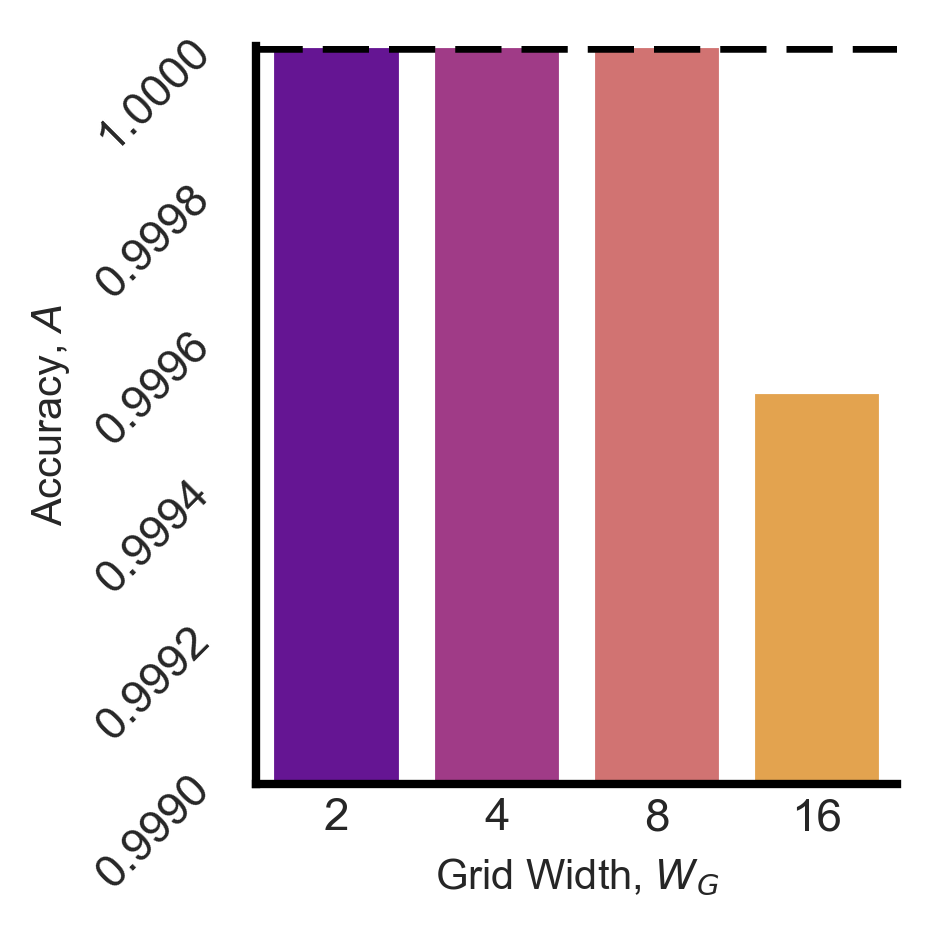

done


In [57]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Read the results CSV file
accuracy_df = pd.read_csv(os.path.join(model_dir, "test_accuracy_results.csv"))

# Group by grid width and calculate mean accuracy
grid_accuracy = accuracy_df.groupby('Grid Width')['Accuracy'].mean()

# Apply the style
sns.set(style="whitegrid", rc={
    'figure.figsize': (3.25, 3.25),
    'figure.dpi': 300,
    'lines.linewidth': 2.0,
    'axes.spines.left': True,
    'axes.spines.bottom': True,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.edgecolor': 'black',
    'axes.linewidth': 2.0,
    'xtick.direction': 'out',
    'ytick.direction': 'out',
    'xtick.major.width': 0,
    'ytick.major.width': 0,
    'xtick.major.size': 0,
    'ytick.major.size': 6,
    'axes.labelsize': 10,
    'axes.titlesize': 10,
    'legend.fontsize': 10,
    'legend.title_fontsize': 10,
    'axes.grid': False
})

# Create a bar plot
plt.figure()
ax = sns.barplot(x=grid_accuracy.index, y=grid_accuracy.values, palette="plasma")

# Set log scale for y-axis
plt.ylim(0.999, 1)
ax.tick_params(axis='y', which='both', labelrotation=45)

#Black dotted line at y=1
plt.axhline(y=1, color='black', linestyle='--', linewidth=3)

# Set plot titles and labels
plt.xlabel('Grid Width, $W_G$')
plt.ylabel('Accuracy, $A$')
plt.grid(False)

plt.tight_layout()
plt.show()
print('done')

No let's test the ability for LifeGPT to generalize for grid sizes it has never seen before.

In [17]:
import torch
import os
import pandas as pd
from x_transformers import TransformerWrapper, Decoder
from x_transformers.autoregressive_wrapper import AutoregressiveWrapper
import numpy as np
import csv

# =============================================================================
#                            Helper Functions
# =============================================================================

def load_saved_model(model_dir, model_name, epoch, max_length, num_words, device):
    """Load the saved model and its weights."""
    model = TransformerWrapper(
        num_tokens=num_words,
        max_seq_len=max_length,
        attn_layers=Decoder(
            dim=256,
            depth=12,
            heads=8,
            attn_dim_head=64,
            rotary_pos_emb=True,
            attn_flash=True
        )
    )
    model = AutoregressiveWrapper(model)
    print(f"Current Working Directory: {os.getcwd()}")
    model_path = os.path.join(model_dir, f"LifeGPT_multi_grid_epoch_{epoch}.pt")
    print("Trying to load model from:", model_path)
    model.load_state_dict(torch.load(model_path))

    model.to(device)
    model.eval()
    print(f"Model for epoch {epoch} loaded successfully.")
    return model


def count_mismatches(ground_truth, pred):
    """Calculate mismatches and accuracy."""
    mismatches = sum(1 for gt, p in zip(ground_truth, pred) if gt != p)
    accuracy = 1 - mismatches / len(ground_truth)
    return mismatches, accuracy


def calculate_grid_width(input_string):
    """Calculate the grid width based on the numerical values in the input string."""
    grid_length = input_string.count("0") + input_string.count("1")
    return int(grid_length ** 0.5) if grid_length > 0 else 0

# =============================================================================
#                            Load Data
# =============================================================================

data_path = "datasets\\"
test_file = os.path.join(data_path, "conway_multi_grid__generalization_test_20250109_121432.csv")

df_test = pd.read_csv(test_file)

# Define parameters
start_char = "@"
end_char = "$"
mask_char = ["_"]
future_steps_list = [2]

# Helper functions for data processing
def generate_data(df, future_steps):
    X_data = []
    for i in range(len(df['State 1'])):
        future_state_col = f"State {future_steps}"
        if future_state_col in df.columns:
            str_ = f"{start_char}PredictNextState<{df['State 1'][i]}> [{df[future_state_col][i]}]{end_char}"
            X_data.append(str_)
    return X_data

X_data_test = {steps: generate_data(df_test, steps) for steps in future_steps_list}

# Tokenizer class from provided code
class Tokenizer:
    def __init__(self, n_pad: int, device: torch.device, pad_byte: int = 0):
        self.n_pad = n_pad
        self.device = device
        self.pad_byte = pad_byte

    def tokenize_str(self, sentence: str, encoding="utf8", do_padding=True):
        base = list(bytes(sentence, encoding))
        if do_padding:
            if len(base) < self.n_pad:
                base.extend([self.pad_byte] * (self.n_pad - len(base)))
            assert len(base) == self.n_pad, f"n_pad is too small. Need at least {len(base)}."
        tensor = torch.Tensor(base)
        return tensor.long().to(self.device)

    def texts_to_sequences(self, texts, encoding="utf8", do_padding=True):
        sentences = [self.tokenize_str(sentence, do_padding=do_padding).unsqueeze(0) for sentence in texts]
        return torch.cat(sentences, dim=0).to(self.device)

    def sequences_to_texts(self, texts, encoding="utf8"):
        out = []
        for seq in texts:
            chars = []
            i = 0
            while i < len(seq) and seq[i] != 0:
                chars.append(int(seq[i]))
                i += 1
            try:
                out.append(bytes(chars).decode(encoding))
            except:
                pass
        return out

# Tokenizer setup
max_length = max(len(seq) for steps in future_steps_list for seq in X_data_test[steps])
num_words = 256
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Instantiate tokenizer
tokenizer_X = Tokenizer(max_length, device)
X_data_test_tokenized = {steps: tokenizer_X.texts_to_sequences(X_data_test[steps]) for steps in future_steps_list}

# =============================================================================
#                        Load Model and Measure Accuracy
# =============================================================================

# Model parameters
model_dir = "model_parameters\\01_07_2025_Conway_Multi_Grid_2025-01-08_13-09-21"
model_name = "LifeGPT_multi_grid"
epoch = 50

# Load model
model = load_saved_model(model_dir, model_name, epoch, max_length, num_words, device)

# CSV file to save results
results_csv = os.path.join(model_dir, "generalization_test_accuracy_results.csv")
with open(results_csv, mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Sample Index", "Grid Width", "Accuracy"])

# Evaluate accuracy
steps = future_steps_list[0]
accuracies = []
mismatches_total = 0

def extract_start_and_end(string_input, start_token='[', end_token=']'):
    i = string_input.find(start_token)
    j = string_input.find(end_token)
    return string_input[i+1:j]

def extract_task(string_input, end_task_token=')'):
    j = string_input.find(end_task_token)
    return string_input[:j+1]

for i, inp_seq in enumerate(X_data_test[steps]):
    # print(f"Inp seq:{inp_seq}")
    inp_str = extract_task(inp_seq, end_task_token=">")
    ground_truth = extract_start_and_end(inp_seq, start_token='[', end_token=']')
    # print(f"Inp str:{inp_str}; Len_inp_str {len(inp_str)}. Ground truth:{ground_truth}")


    # Calculate grid width
    grid_width = calculate_grid_width(inp_str)

    # Tokenize input sequence
    inp = torch.Tensor(tokenizer_X.texts_to_sequences(inp_str, do_padding=False)).to(device)
    inp = inp.transpose(0, 1)
    inp = inp.long()

    with torch.no_grad():
        sample = model.generate(prompts=inp, seq_len=max_length - len(inp_str), cache_kv=True, temperature = 0)
        try:
            output_str = tokenizer_X.sequences_to_texts(sample[:1])[0]
            print(f"Model Output: {output_str}")
            pred = extract_start_and_end(output_str, start_token="[", end_token="]")
            # print(pred)
            # print(ground_truth)
            mismatches, acc = count_mismatches(ground_truth, pred)
            mismatches_total += mismatches
            accuracies.append(acc)
            print(f"Acc: {acc}")

            # Save results to CSV
            with open(results_csv, mode="a", newline="") as file:
                writer = csv.writer(file)
                writer.writerow([i, grid_width, acc])

        except Exception as e:
            print(f"Error processing sample {i}: {e}")
            accuracies.append(0)
            with open(results_csv, mode="a", newline="") as file:
                writer = csv.writer(file)
                writer.writerow([i, grid_width, 0])

# Report accuracy
average_accuracy = np.mean(accuracies)
print(f"Average Accuracy over {len(accuracies)} samples: {average_accuracy * 100:.2f}%")
print(f"Results saved to {results_csv}")


Device: cuda
Current Working Directory: c:\Users\jaime\ML_Playground_1\LifeGPT\Multi_Grid
Trying to load model from: model_parameters\01_07_2025_Conway_Multi_Grid_2025-01-08_13-09-21\LifeGPT_multi_grid_epoch_50.pt
Model for epoch 50 loaded successfully.
Model Output: 000000000000000000000000000000> [0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
Acc: 1.0
Model Output:  ppppppppppppppppppppppppppppp0> [000000000000000010000000000000011000000000000000000000000000000000000000000000000000000000000000000000000000000000100000010000000000000010000000000010000000000000000000000000000000000000000000000
Acc: 0.9288888888888889
Model Output:  [0000000000000000000000000000> [0000000000000000011100000000100011000000000001111001000000000101000000000000000110000111000110100000010000000000000001000000000000001100000000001000101000000001111101000000000101